In [83]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [84]:
data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/ce464a22bb04cc7276267c1d8a1d26c0/asset-v1:Skillfactory+DST-PRO+15APR2020+type@asset+block/train-scoring.csv')

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [86]:
# удаляем ненужный столбец
data.drop(['client_id'], axis=1, inplace=True)

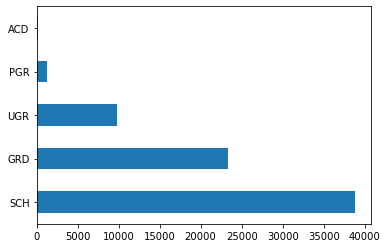

In [87]:
# смотрим на распределение признака с пропусками
data['education'].value_counts().plot.barh()

In [88]:
# заменяем с помощью вероятностного присвоения
mask = data["education"].isna()
# считаем статистику распределения значений
p = data["education"].value_counts() / len(data["education"].dropna())
# заполняем пропуски с вероятностью `p`
data.loc[mask, "education"] = \
    np.random.choice(p.index.to_list(), 
                     size=mask.sum(), 
                     p=p.to_list())

In [89]:
# чтобы отобразить распределение более нормално, логарифмируем некоторые переменные
data['age'] = np.log(data['age'])
data['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: np.log(x) if x>0 else x)
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: np.log(x) if x>0 else x)

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


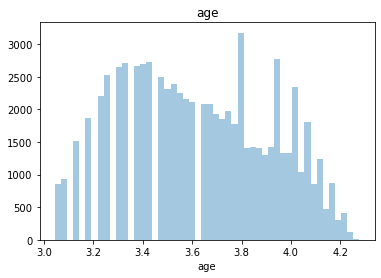

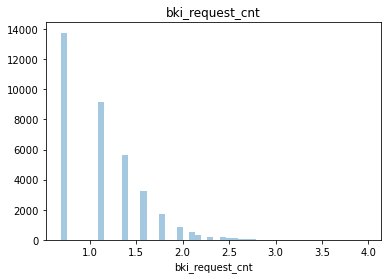

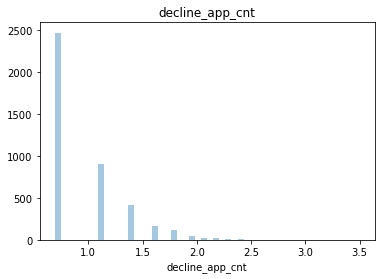

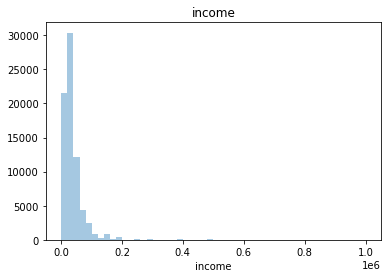

In [90]:
# построим графики распределения количественных переменных
for i in data[['age','bki_request_cnt', 'decline_app_cnt', 'income']]:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

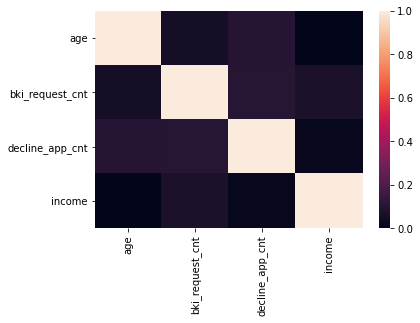

In [91]:
# оценим корреляцию Пирсона для непрерывных переменных:
sns.heatmap(data[['age','bki_request_cnt', 'decline_app_cnt', 'income']].corr().abs(), vmin=0, vmax=1)

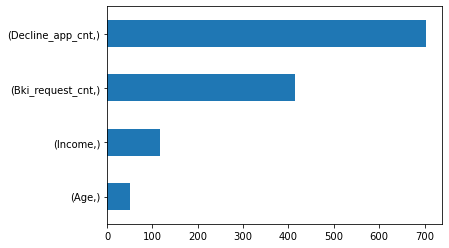

In [92]:
# Оценим значимость числовых переменных

imp_num = pd.Series(f_classif(data[['age','bki_request_cnt', 'decline_app_cnt', 'income']], data['default'])[0]
                   , index = [['Age', 'Bki_request_cnt', 'Decline_app_cnt', 'Income']])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [93]:
# заменяем бинарные категориальные признаки

label_encoder = LabelEncoder()
for column in data[['sex', 'car','car_type', 'foreign_passport', 'home_address', 'work_address', 'education']]:
    data[column] = label_encoder.fit_transform(data[column]) 

In [94]:
data[['sex', 'car','car_type', 'foreign_passport', 'home_address', 'work_address', 'education']]

,sex,car,car_type,foreign_passport,home_address,work_address,education
0,1,1,1,0,0,1,3
1,0,0,0,0,1,2,3
2,1,1,0,1,0,1,3
3,0,0,0,0,1,2,3
4,1,0,0,1,1,2,1
...,...,...,...,...,...,...,...
73794,0,0,0,0,0,1,1
73795,1,1,1,0,1,1,3
73796,1,0,0,0,1,2,3
73797,0,0,0,0,0,2,3


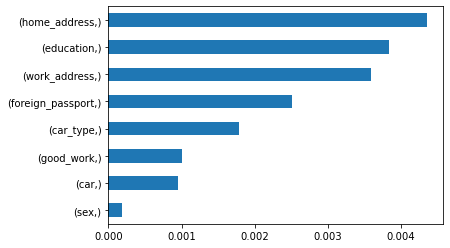

In [95]:
# произведём оценку значимости категориальных бинарных переменных
imp_cat = Series(mutual_info_classif(data[['sex', 'car', 'car_type', 'good_work', 'foreign_passport'
                                           , 'home_address', 'work_address', 'education']], data['default'],
                                     discrete_features =True), index = [['sex', 'car', 'car_type', 'good_work'
                                     , 'foreign_passport', 'home_address', 'work_address', 'education']])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [96]:
# воспользуемся dummy-кодированием для категориальных переменных
X_cat = OneHotEncoder(sparse=False).fit_transform(data[['education', 'work_address', 'home_address']].values)

In [97]:
# cтандартизируем числовые переменные
X_num = StandardScaler().fit_transform(data[['age','bki_request_cnt', 'decline_app_cnt', 'income']].values)

In [271]:
# объединим
X = np.hstack([X_num, data[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']].values, X_cat])
y = data['default'].values

In [272]:
# сплитим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [276]:
# обучаем модель
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


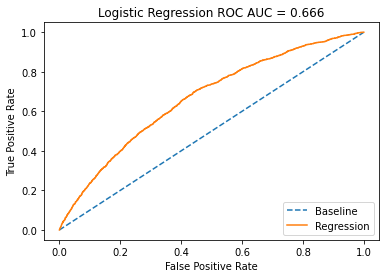

In [285]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()